In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import cx_Oracle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('fr_food_n_acc_1st_orders.dsv', sep=';', low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820809 entries, 0 to 1820808
Data columns (total 27 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            object
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   object
SCM_SALES_CANCEL_BMF            object
SCM_D_FINANCE_CM1               object
SCM_D_FINANCE_CM2               object
SCM_D_ORIG_FINANCE_ORDER_NET    object
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
SCM_IS_ZSP_ORDER                int64
SCM_C_ORDER_STATUS              object
CTP_N_KEY_CUSTOMER_TYPE         int64
SCM_OCI_LAND                    object
SCM_D_FC_ID                     int64
SCM_D_PC_DSP                    int64
SCM_FC_SPLIT                    int64
OSP_KO_COUNT                    int64
OSP_KO_COUNT_NET                int64
OSP_

In [4]:
data['ORDER_DATETIME'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'] + ' ' + data['THR_C_KEY_ORDER_HOUR'] + ':00', 
                                        format="%d/%m/%y %H:%M:%S")

In [5]:
data['TDT_T_KEY_ORDER_DATE'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'], format="%d/%m/%y")

In [6]:
lista = [float(str(i).replace(',','.')) for i in data['SCM_SALES_BMF'].values]
data['SCM_SALES_BMF'] = lista

In [7]:
lista0 = [float(str(i).replace(',','.')) for i in data['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
data['SCM_D_ORIG_FINANCE_ORDER_NET'] = lista0

In [8]:
lista1 = [float(str(i).replace(',','.')) for i in data['SCM_SALES_CANCEL_BMF'].values]
data['SCM_SALES_CANCEL_BMF'] = lista1

In [9]:
lista2 = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM1'].values]
data['SCM_D_FINANCE_CM1'] = lista2

In [10]:
lista3 = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM2'].values]
data['SCM_D_FINANCE_CM2'] = lista3

In [11]:
data['FINANCE_ORDER_NET'] = data['SCM_D_ORIG_FINANCE_ORDER_NET'].groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [12]:
data['REL_CM1'] = data['SCM_D_FINANCE_CM1'] / data['FINANCE_ORDER_NET'] * 100

In [13]:
data['REL_CM2'] = data['SCM_D_FINANCE_CM2'] / data['FINANCE_ORDER_NET'] * 100

In [14]:
# let's convert inf and -inf into NA so that they are excluded when calculating the mean
data['REL_CM2'] = data['REL_CM2'].replace(np.inf, np.nan).replace(-np.inf, np.nan)

In [15]:
#Convert date to calendar week number and month number
data['WEEK_NUMBER'] = data['TDT_T_KEY_ORDER_DATE'].dt.week
data['MONTH_NUMBER'] = data['TDT_T_KEY_ORDER_DATE'].dt.month

Let's get PG3 & PG4 short_link names from our DB to make data more readable...

In [16]:
pg3_l = list(data['OSP_3_LEAD_P_PG_ID'].fillna(0).unique())

In [17]:
pg3_list = repr(pg3_l).replace('[','(').replace(']',')')

In [18]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_list

In [19]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
curs = conn.cursor()
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [20]:
pg3['PG_SHORTLINK_ID'] = pg3['PG_SHORTLINK'] + '_' + pg3['PG_ID'].astype(str)

In [21]:
len(set(pg3['PG_ID'])), len(set(pg3['PG_SHORTLINK_ID']))

(63, 63)

In [22]:
pg3

,PG_ID,PG_SHORTLINK,PG_SHORTLINK_ID
0,9,hundebett,hundebett_9
1,15,hundeleine_hundehalsband,hundeleine_hundehalsband_15
2,16,fressnapf,fressnapf_16
3,18,hundesnacks,hundesnacks_18
4,20,hundespielzeug,hundespielzeug_20
5,23,kratzbaum_katzenbaum,kratzbaum_katzenbaum_23
6,29,katzentoilette,katzentoilette_29
7,33,fressnapf,fressnapf_33
8,34,katzensnacks,katzensnacks_34
9,36,katzenspielzeug,katzenspielzeug_36


In [23]:
pg3_dict = {key: value for (key, value) in zip(pg3['PG_ID'], pg3['PG_SHORTLINK_ID'])}

In [24]:
pg3_dict[0] = 'null'

In [25]:
lista_pg3 = [pg3_dict[i] for i in data['OSP_3_LEAD_P_PG_ID'].fillna(0)]

In [26]:
len(lista_pg3), len(data['OSP_3_LEAD_P_PG_ID'])

(1820809, 1820809)

In [27]:
data['LEAD_PG3_NAME'] = lista_pg3

In [28]:
pg4_l = list(data['OSP_4_LEAD_P_PG_ID'].fillna(0).unique())

In [29]:
pg4_list = repr(pg4_l).replace('[','(').replace(']',')')

In [30]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg4_list

In [31]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
curs = conn.cursor()
pg4 = pd.read_sql(query, con = conn)
conn.close()

In [32]:
pg4_dict = {key: value for (key, value) in zip(pg4['PG_ID'], pg4['PG_SHORTLINK'])}

In [33]:
pg4_dict[-1] = 'null'

In [34]:
lista_pg4 = [pg4_dict[i] for i in data['OSP_4_LEAD_P_PG_ID'].fillna(-1)]

In [35]:
len(lista_pg4), len(data['OSP_4_LEAD_P_PG_ID'])

(1820809, 1820809)

In [36]:
data['LEAD_PG4_NAME'] = lista_pg4

In [37]:
data[['OSP_3_LEAD_P_PG_ID', 'LEAD_PG3_NAME', 'OSP_4_LEAD_P_PG_ID', 'LEAD_PG4_NAME']].sample(5)

,OSP_3_LEAD_P_PG_ID,LEAD_PG3_NAME,OSP_4_LEAD_P_PG_ID,LEAD_PG4_NAME
820762,20,hundespielzeug_20,465,kong
346756,2068,katzenfutter_dose_2068,17963,royal_canin_katzenfutter
261092,251,hundefutter_trockenfutter_251,682,royal_canin_size
781120,251,hundefutter_trockenfutter_251,283,pro_plan
584002,2068,katzenfutter_dose_2068,9498,sheba


In [38]:
first_orders = data[data['OSP_KO_COUNT_NET'] == 1]

In [39]:
cus_pg3_1st = {}

for i in first_orders['CUS_N_KEY_CUSTOMER'].unique():
    cus_data = first_orders[first_orders['CUS_N_KEY_CUSTOMER'] == i]
    cus_pg3_1st[i] = cus_data['LEAD_PG3_NAME'].iloc[0]

In [40]:
cus_pg3_1st

{16971691: 'hundesnacks_18',
 16971562: 'katzenstreu_301',
 16969960: 'hundefutter_trockenfutter_251',
 16972220: 'katzentoilette_29',
 16971628: 'hundetransportbox_2190',
 16969959: 'katzenfutter_trockenfutter_252',
 16972208: 'hundebett_9',
 16969808: 'balkon_garten_2155',
 16976735: 'hundefutter_trockenfutter_251',
 16969979: 'katzenfutter_trockenfutter_252',
 16973723: 'katzenfutter_trockenfutter_252',
 16973836: 'katzenfutter_trockenfutter_252',
 16978031: 'katzenfutter_trockenfutter_252',
 16972744: 'hundefutter_trockenfutter_251',
 16977765: 'katzenfutter_trockenfutter_252',
 16977860: 'katzenfutter_dose_2068',
 16977880: 'katzenfutter_trockenfutter_252',
 16974858: 'hundefutter_trockenfutter_251',
 16973724: 'katzenfutter_dose_2068',
 16368125: 'hundefutter_trockenfutter_251',
 16976957: 'hundefutter_trockenfutter_251',
 16973790: 'katzenfutter_trockenfutter_252',
 16977950: 'katzenfutter_trockenfutter_252',
 16977960: 'katzenbetten_katzenkissen_1540',
 16979006: 'katzentoilett

In [41]:
cus_pg3_1st_list = [cus_pg3_1st[i] for i in data['CUS_N_KEY_CUSTOMER'].values]

In [42]:
len(data['CUS_N_KEY_CUSTOMER']) == len(cus_pg3_1st_list)

True

In [43]:
data['LEAD_PG3_1ST_ORD'] = cus_pg3_1st_list

In [44]:
cm2_pg3_to_pg4 = data.groupby(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER', 
                                   'OSP_3_LEAD_P_PG_ID', 'LEAD_PG3_NAME', 'OSP_4_LEAD_P_PG_ID', 'LEAD_PG4_NAME', 
                                   'LEAD_PG3_1ST_ORD'], as_index=False).agg({'SCM_D_FINANCE_CM2': 'sum',
                                                                        'OSP_KO_COUNT_NET': 'mean',
                                                                            'REL_CM2': 'sum',
                                                                            'SCM_D_ORIG_FINANCE_ORDER_NET':'sum'})

In [45]:
cm2_pg3_to_pg4.sample(10)

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,OSP_3_LEAD_P_PG_ID,LEAD_PG3_NAME,OSP_4_LEAD_P_PG_ID,LEAD_PG4_NAME,LEAD_PG3_1ST_ORD,SCM_D_FINANCE_CM2,OSP_KO_COUNT_NET,REL_CM2,SCM_D_ORIG_FINANCE_ORDER_NET
107336,93633901,2017-09-02,17790795,153317,sport_training_153317,153278,fahrradkorb,sport_training_153317,6.3558,1,16.678213,38.1084
104165,93518316,2017-08-31,17772090,37,transport_37,543,weidenhoehlen,transport_37,13.5094,1,21.336235,63.3167
170850,95910519,2017-10-08,17664793,20,hundespielzeug_20,465,kong,hundebett_9,17.0385,3,28.923768,58.9083
375274,103263802,2018-01-25,18297545,251,hundefutter_trockenfutter_251,682,royal_canin_size,hundefutter_trockenfutter_251,-1.1789,3,-1.604129,73.4916
419327,106023819,2018-03-06,18555902,252,katzenfutter_trockenfutter_252,81397,royal_canin_veterinary_diet,katzenfutter_trockenfutter_252,1.6374,2,3.388308,48.3250
221449,97569195,2017-11-02,18402159,252,katzenfutter_trockenfutter_252,683,royal_canin,katzenfutter_trockenfutter_252,2.7418,1,10.759203,25.4833
140725,94879460,2017-09-21,14713842,251,hundefutter_trockenfutter_251,180361,hundefutter_wolf_of_wilderness,hundefutter_trockenfutter_251,18.1162,1,30.396309,59.6000
218322,97473793,2017-11-01,18387745,252,katzenfutter_trockenfutter_252,201878,concept_for_life_cat,katzenfutter_trockenfutter_252,4.2312,1,22.104620,19.1417
148158,95161548,2017-09-26,18020132,2155,balkon_garten_2155,2156,katzennetz,katzenfutter_trockenfutter_252,4.3426,3,27.268903,15.9251
138623,94797881,2017-09-20,17507741,252,katzenfutter_trockenfutter_252,683,royal_canin,katzenspielzeug_36,2.8829,2,4.759884,60.5666


In [46]:
cm2_pg3_to_pg4['LEAD_PG3_1ST_ORD'].unique()

array(['balkon_garten_2155', 'katzenfutter_trockenfutter_252',
       'kratzbaum_katzenbaum_23', 'hundefutter_trockenfutter_251',
       'katzentoilette_29', 'katzenfutter_dose_2068', 'hundebett_9',
       'katzenbetten_katzenkissen_1540', 'sport_training_153317',
       'transport_37', 'hundetransportbox_2190',
       'ungezieferschutz_207553', 'futter_45', 'fressnapf_33',
       'hundefutter_ergaenzung_1400', 'hundepflege_409',
       'katzenstreu_301', 'fressnapf_16', 'ungezieferschutz_207624',
       'hundespielzeug_20', 'hundeleine_hundehalsband_15',
       'katzenspielzeug_36', 'hundesnacks_18', 'freigehege_49828',
       'hundefutter_nassfutter_857', 'futter_ergaenzung_401',
       'hundehuette_hundetuer_2192', 'heu_streu_305', 'spielzeug_47',
       'hundebekleidung_hundemantel_40023', 'katzensnacks_34',
       'barf_183134', 'katzenfutter_ergaenzung_38', 'spielzeug_1603',
       'superbox_dog_255413'], dtype=object)

In [47]:
crosstab_ko_count_net = pd.crosstab(cm2_pg3_to_pg4['LEAD_PG3_1ST_ORD'], cm2_pg3_to_pg4['OSP_KO_COUNT_NET'], 
                                           values = cm2_pg3_to_pg4['SCM_N_ORDER_NR'],
                                          aggfunc='count').fillna(0).astype(int)

In [48]:
crosstab_ko_count_net

OSP_KO_COUNT_NET,1,2,3,4,5
LEAD_PG3_1ST_ORD,,,,,
balkon_garten_2155,4675,1085,567,357,237
barf_183134,144,67,49,26,21
freigehege_49828,1230,345,173,111,74
fressnapf_16,1088,374,248,177,139
fressnapf_33,4207,1408,828,534,374
futter_45,2058,1022,631,355,245
futter_ergaenzung_401,264,113,64,30,18
heu_streu_305,1151,609,397,233,148
hundebekleidung_hundemantel_40023,1125,303,125,68,50


In [50]:
next_orders = cm2_pg3_to_pg4[cm2_pg3_to_pg4['OSP_KO_COUNT_NET'] != 1]

In [51]:
crosstab_pg3_to_pg4_orders = pd.crosstab(next_orders['LEAD_PG3_1ST_ORD'], next_orders['LEAD_PG4_NAME'], 
                                           values = next_orders['SCM_N_ORDER_NR'],
                                          aggfunc='count').fillna(0).astype(int).apply(lambda x: x/x.sum() * 100, axis=1).round(2)

In [52]:
crosstab_pg3_to_pg4_orders

LEAD_PG4_NAME,_lampen,acana,adult,advance,advance_breed,affinity_advance,affinity_advance_veterinary_diets,affinity_ultima,agility,algenbekaempfung,...,zimmerkaefig,zoolove,zoolove_snacks,zooplus,zooplus_bio,zooplus_branded,zooplus_classic,zooplus_geschenkgutschein,zubehoer,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,0.00,0.40,0.00,0.00,0.00,0.04,0.00,0.58,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.36
barf_183134,0.00,1.84,7.36,0.00,0.00,0.00,0.61,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
freigehege_49828,0.00,0.28,0.00,0.00,0.00,0.00,0.14,0.14,0.14,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,13.23
fressnapf_16,0.00,2.03,0.00,0.00,0.00,0.00,0.32,0.11,0.21,0.00,...,0.11,0.00,0.00,0.00,0.00,0.0,0.00,0.11,0.00,0.11
fressnapf_33,0.00,0.67,0.00,0.00,0.06,0.16,0.06,0.22,0.06,0.00,...,0.00,0.03,0.00,0.00,0.00,0.0,0.00,0.06,0.03,0.06
futter_45,0.00,0.00,0.00,0.00,0.00,0.09,0.04,0.27,0.04,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,40.75
futter_ergaenzung_401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.44,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,19.11
heu_streu_305,0.00,0.07,0.00,0.00,0.00,0.00,0.29,0.07,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,14.13
hundebekleidung_hundemantel_40023,0.00,0.92,0.00,0.18,0.18,0.00,0.18,0.37,0.37,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00


In [53]:
crosstab_pg3_to_pg4_orders.columns.ravel()

array(['_lampen', 'acana', 'adult', 'advance', 'advance_breed',
       'affinity_advance', 'affinity_advance_veterinary_diets',
       'affinity_ultima', 'agility', 'algenbekaempfung',
       'alle_hundenaepfe', 'alle_zubehoerartikel', 'almo_nature',
       'almo_nature_holistic', 'almo_nature_labels', 'alpha_spirit',
       'animonda', 'animonda_rafine', 'animonda_rafinee',
       'antizug_maulkorb', 'applaws', 'applaws_katzenfutter',
       'applaws_natures_calling', 'aquarien_komplett',
       'aquarium_aussenfilter', 'aquarium_filter',
       'aquarium_unterschrank', 'aquarium_zubehoer', 'arden_grange',
       'arden_grange_katzenfutter', 'arden_grange_partners',
       'aufbau_leistung_zucht', 'augen_ohren', 'augen_ohrenpflege',
       'augenpflege', 'aussergewoehnliche_katzenbetten',
       'autoschondecken', 'autoschutzgitter', 'bade_sand', 'badehaeuser',
       'baelle', 'baldrian_katzenspielzeug', 'barking_heads', 'beaphar',
       'beaphar_spezialdiaet', 'belcando', 'benek', 

In [54]:
pg4_selection = [i for i in crosstab_pg3_to_pg4_orders.columns if (crosstab_pg3_to_pg4_orders[i] > 5).any()]

In [55]:
len(pg4_selection)

54

In [56]:
np.array(pg4_selection)

array(['adult', 'almo_nature', 'cats_best', 'catsan',
       'cellulose_einstreu', 'erziehungshalsband', 'faltbare_hundebox',
       'felix', 'frostfleisch_mixpakete', 'futterpflanzen', 'gefluegel',
       'gefriergetrocknete_snacks', 'gelenke_knochen', 'geschirre',
       'grosssittich', 'halsband', 'hanfstreu', 'haut_haare', 'heu',
       'hills', 'hills_prescription_diet', 'hundemantel', 'hundeschuhe',
       'katzenklappe_und_einbautuer', 'katzentraenke', 'kauknochen',
       'kaustreifen', 'knabberspass_und_knabberstangen', 'knuspersnacks',
       'kong', 'lukullus_hundefutter', 'meerschweinchen', 'metall',
       'papagei', 'pasten_cremes', 'pedigree', 'pro_plan', 'purizon',
       'rind', 'royal_canin', 'royal_canin_breed',
       'royal_canin_katzenfutter', 'royal_canin_size',
       'royal_canin_vet_care_nutrition', 'royal_canin_veterinary_diet',
       'royal_canin_veterinary_diet_feline_nassfutter', 'spoton',
       'tigerino', 'toilette', 'verhalten_wohlfuehlen_katzen', 'vi

In [57]:
crosstab_pg3_to_pg4_orders[pg4_selection]

LEAD_PG4_NAME,adult,almo_nature,cats_best,catsan,cellulose_einstreu,erziehungshalsband,faltbare_hundebox,felix,frostfleisch_mixpakete,futterpflanzen,...,royal_canin_veterinary_diet,royal_canin_veterinary_diet_feline_nassfutter,spoton,tigerino,toilette,verhalten_wohlfuehlen_katzen,vitamine,zahnpflege_snacks,zooplus_classic,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,0.00,1.20,1.29,0.80,0.00,0.27,0.00,1.38,0.00,0.00,...,2.36,0.27,1.56,2.14,0.22,1.42,0.09,0.00,0.00,0.36
barf_183134,7.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.27,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.61,0.61,0.00,0.00
freigehege_49828,0.00,0.00,0.28,0.14,0.71,0.28,0.71,0.71,0.00,0.43,...,1.28,0.71,0.57,0.57,1.71,0.28,0.14,0.43,0.00,13.23
fressnapf_16,0.00,0.85,1.17,0.11,0.00,0.75,0.00,1.07,0.00,0.00,...,1.28,0.64,0.53,0.75,0.96,0.11,0.21,0.85,0.00,0.11
fressnapf_33,0.00,1.24,1.27,0.83,0.00,0.06,0.03,0.86,0.00,0.03,...,3.75,1.46,0.67,3.75,0.03,1.65,0.06,0.13,0.00,0.06
futter_45,0.00,0.49,1.11,0.04,0.80,0.09,0.04,0.58,0.00,0.13,...,0.89,0.00,0.49,0.49,0.22,0.13,0.04,0.18,0.00,40.75
futter_ergaenzung_401,0.00,0.00,0.89,0.00,1.33,0.00,0.44,0.44,0.00,10.67,...,0.00,0.00,0.44,0.44,0.00,0.00,0.44,0.00,0.00,19.11
heu_streu_305,0.00,0.14,0.50,0.22,10.53,0.00,0.07,0.00,0.00,0.29,...,0.87,0.00,0.29,0.72,0.29,0.14,0.00,0.14,0.00,14.13
hundebekleidung_hundemantel_40023,0.00,0.00,0.00,0.00,0.00,0.55,0.00,0.18,0.00,0.00,...,4.95,0.18,0.73,0.18,0.73,0.00,0.18,1.28,0.00,0.00


In [58]:
crosstab_pg3_to_pg4_orders[pg4_selection].to_csv('fr_rel_orders_lead_pg3_and_pg4_selection.csv', sep=';', index=True, encoding='utf-8')

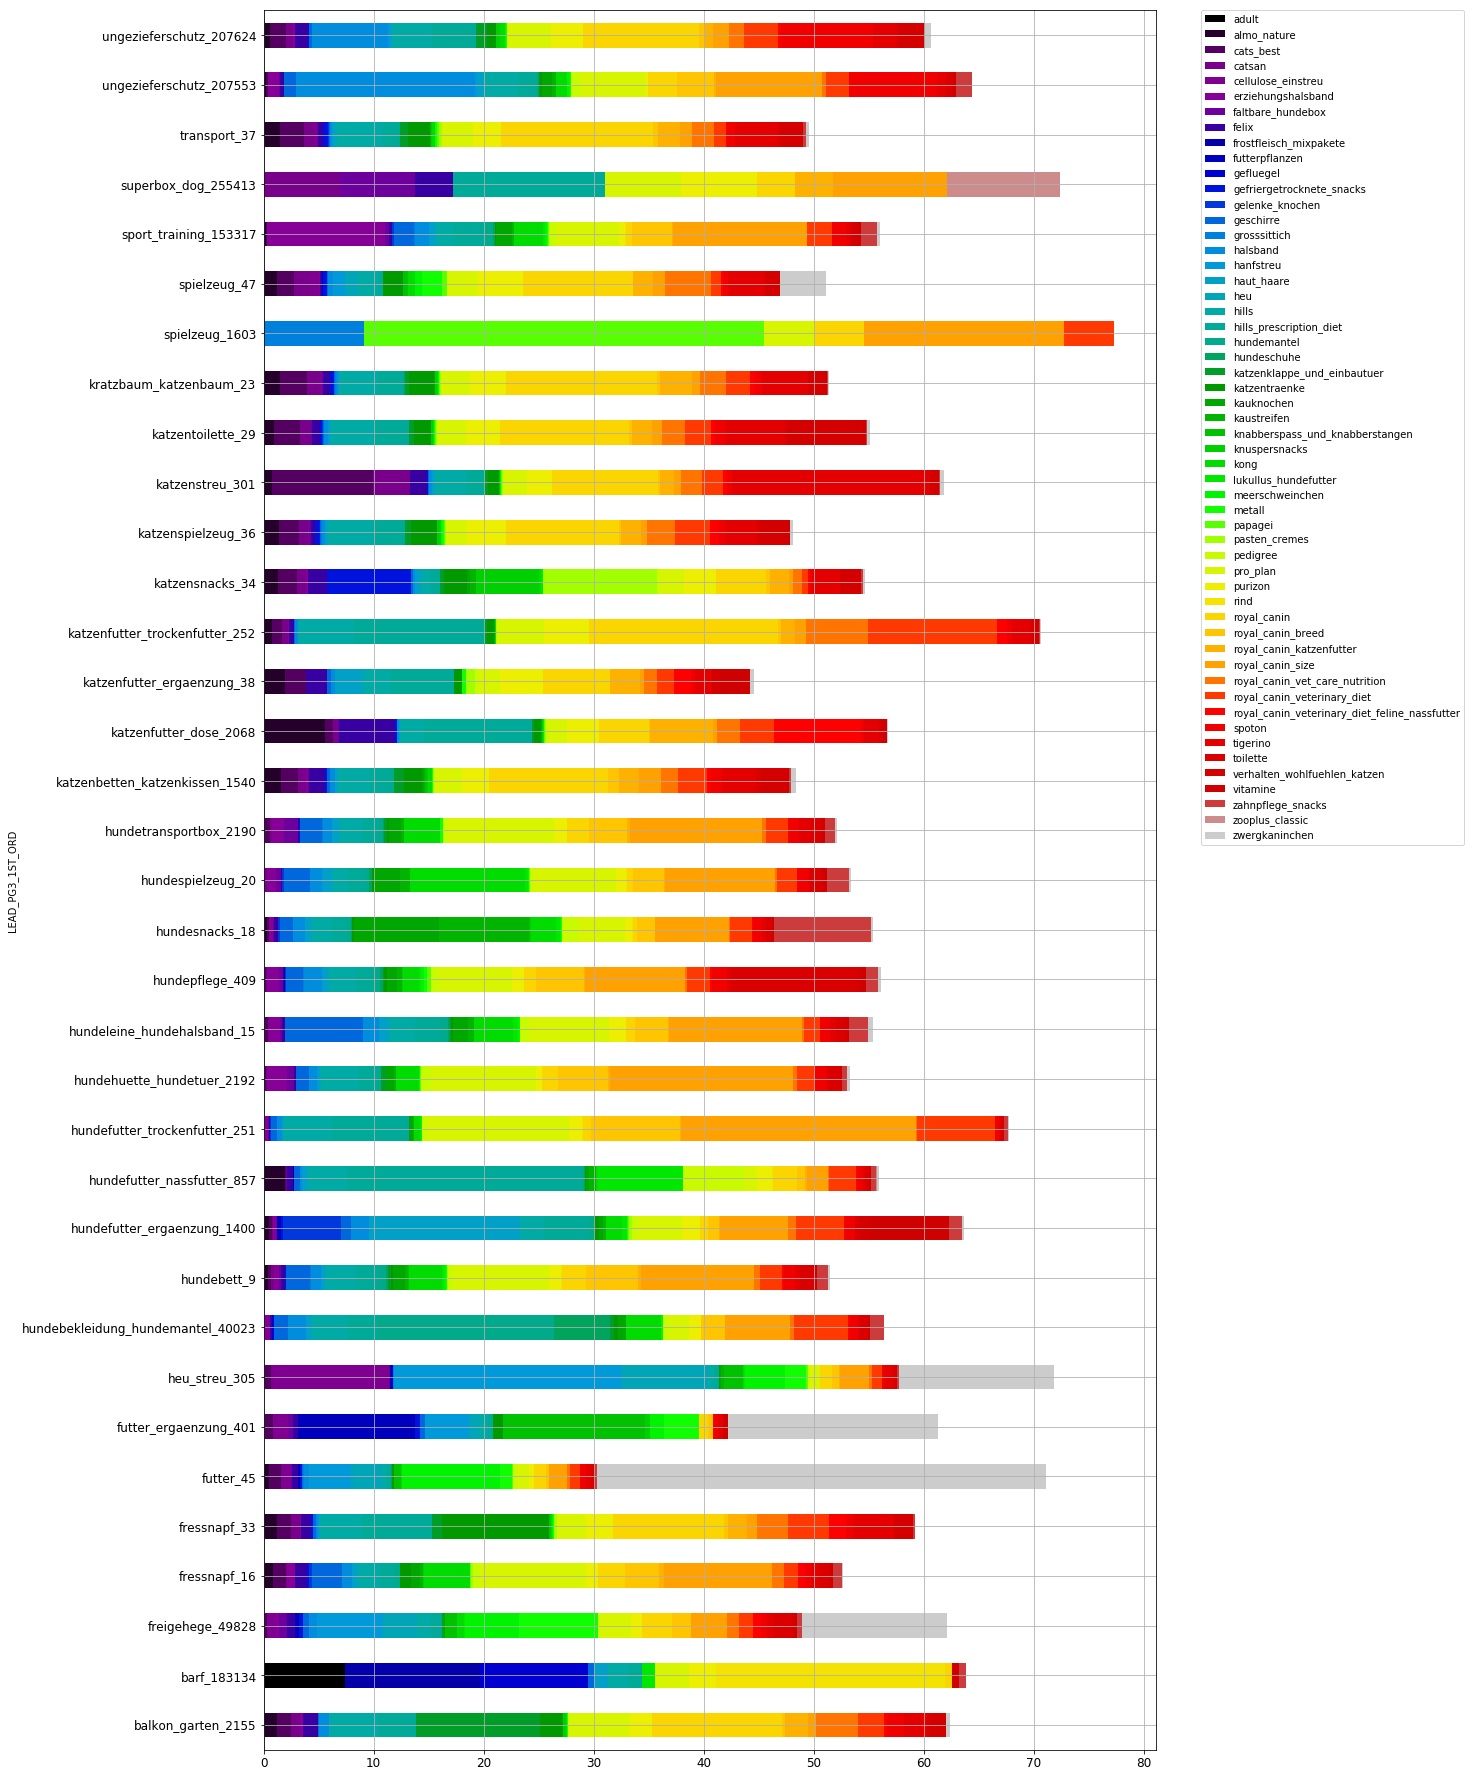

In [59]:
crosstab_pg3_to_pg4_orders[pg4_selection].plot(kind='barh', stacked=True, figsize=(16, 32), grid=True, fontsize=12, colormap='nipy_spectral')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.tight_layout()
#plt.savefig('rel_orders_accesories_and_pg4_sel')

In [60]:
crosstab_pg3_to_pg4_cm2 = pd.crosstab(cm2_pg3_to_pg4['LEAD_PG3_1ST_ORD'], cm2_pg3_to_pg4['OSP_KO_COUNT_NET'], 
                                           values = cm2_pg3_to_pg4['SCM_D_FINANCE_CM2'],
                                          aggfunc='sum').fillna(0).round(2)

In [61]:
crosstab_pg3_to_pg4_cm2

OSP_KO_COUNT_NET,1,2,3,4,5
LEAD_PG3_1ST_ORD,,,,,
balkon_garten_2155,33382.36,6912.75,3622.65,2374.72,1625.43
barf_183134,1728.24,789.33,695.82,309.36,296.95
freigehege_49828,12354.56,2823.65,1333.29,794.82,581.39
fressnapf_16,6251.79,3040.24,2029.68,1493.66,1075.91
fressnapf_33,32586.70,9841.02,6350.10,3845.71,2919.82
futter_45,10324.99,6595.57,4574.83,2776.02,1865.38
futter_ergaenzung_401,1132.01,671.22,395.15,205.35,188.95
heu_streu_305,6867.68,4108.49,3308.88,1783.43,1294.15
hundebekleidung_hundemantel_40023,10544.32,2496.48,979.08,632.51,443.18


In [62]:
crosstab_pg3_to_pg4_perc_cm2 = pd.crosstab(next_orders['LEAD_PG3_1ST_ORD'], next_orders['LEAD_PG4_NAME'], 
                                           values = next_orders['SCM_D_FINANCE_CM2'],
                                          aggfunc='sum').fillna(0).astype(int).apply(lambda x: x/x.sum() * 100, axis=1).round(2)

In [63]:
crosstab_pg3_to_pg4_perc_cm2

LEAD_PG4_NAME,_lampen,acana,adult,advance,advance_breed,affinity_advance,affinity_advance_veterinary_diets,affinity_ultima,agility,algenbekaempfung,...,zimmerkaefig,zoolove,zoolove_snacks,zooplus,zooplus_bio,zooplus_branded,zooplus_classic,zooplus_geschenkgutschein,zubehoer,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,0.00,0.81,0.00,0.00,0.00,-0.01,0.00,-0.22,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.37
barf_183134,0.00,3.28,7.77,0.00,0.00,0.00,-0.05,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00
freigehege_49828,0.00,0.26,0.00,0.00,0.00,0.00,0.18,0.02,0.51,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,12.59
fressnapf_16,0.00,4.34,0.00,0.00,0.00,0.00,0.00,-0.01,0.37,0.00,...,0.29,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.22
fressnapf_33,0.00,1.21,0.00,0.00,0.10,-0.04,-0.02,-0.05,0.14,0.00,...,0.00,0.03,0.00,0.00,0.00,0.0,0.00,0.0,0.03,0.05
futter_45,0.00,0.00,0.00,0.00,0.00,0.08,0.01,0.03,0.09,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,37.76
futter_ergaenzung_401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.63,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,15.11
heu_streu_305,0.00,0.26,0.00,0.00,0.00,0.00,0.03,0.03,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,13.22
hundebekleidung_hundemantel_40023,0.00,1.91,0.00,0.16,0.00,0.00,0.04,0.22,0.76,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00


In [64]:
crosstab_pg3_to_pg4_perc_cm2.columns.ravel()

array(['_lampen', 'acana', 'adult', 'advance', 'advance_breed',
       'affinity_advance', 'affinity_advance_veterinary_diets',
       'affinity_ultima', 'agility', 'algenbekaempfung',
       'alle_hundenaepfe', 'alle_zubehoerartikel', 'almo_nature',
       'almo_nature_holistic', 'almo_nature_labels', 'alpha_spirit',
       'animonda', 'animonda_rafine', 'animonda_rafinee',
       'antizug_maulkorb', 'applaws', 'applaws_katzenfutter',
       'applaws_natures_calling', 'aquarien_komplett',
       'aquarium_aussenfilter', 'aquarium_filter',
       'aquarium_unterschrank', 'aquarium_zubehoer', 'arden_grange',
       'arden_grange_katzenfutter', 'arden_grange_partners',
       'aufbau_leistung_zucht', 'augen_ohren', 'augen_ohrenpflege',
       'augenpflege', 'aussergewoehnliche_katzenbetten',
       'autoschondecken', 'autoschutzgitter', 'bade_sand', 'badehaeuser',
       'baelle', 'baldrian_katzenspielzeug', 'barking_heads', 'beaphar',
       'beaphar_spezialdiaet', 'belcando', 'benek', 

In [65]:
pg4_cm2_selection = [i for i in crosstab_pg3_to_pg4_perc_cm2.columns if (crosstab_pg3_to_pg4_perc_cm2[i] > 5).any()]

In [66]:
len(pg4_cm2_selection)

60

In [67]:
crosstab_pg3_to_pg4_perc_cm2[pg4_cm2_selection]

LEAD_PG4_NAME,adult,almo_nature,applaws,catsan,cellulose_einstreu,erziehungshalsband,faltbare_hundebox,felix,feringa,frettchen,...,royal_canin_size,royal_canin_veterinary_diet,spray,tigerino,toilette,transport_und_sicherheit,transportkaefige,vitamine,zooplus_classic,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,0.00,1.16,0.24,0.37,0.00,0.41,0.00,0.36,1.13,0.00,...,0.60,1.54,0.03,2.28,0.33,0.00,0.17,0.18,0.00,0.37
barf_183134,7.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.43,-0.10,0.00,0.00
freigehege_49828,0.00,0.00,0.00,0.13,0.42,0.26,1.39,-0.09,0.44,0.99,...,1.79,1.02,0.00,0.60,1.74,0.00,1.52,0.15,0.00,12.59
fressnapf_16,0.00,0.94,0.00,0.01,0.00,0.65,0.00,0.38,-0.01,0.30,...,4.25,0.90,0.07,0.83,0.93,0.00,2.68,0.28,0.00,0.22
fressnapf_33,0.00,1.19,0.20,0.52,0.00,0.06,0.02,0.15,1.87,0.00,...,0.69,2.29,0.00,3.07,0.03,0.00,0.12,0.04,0.00,0.05
futter_45,0.00,0.57,0.00,0.03,0.53,0.11,0.14,0.22,0.62,7.78,...,1.32,0.79,0.00,0.27,0.27,0.00,0.27,0.05,0.00,37.76
futter_ergaenzung_401,0.00,0.00,0.00,0.00,2.16,0.00,0.42,0.00,0.00,3.34,...,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.28,0.00,15.11
heu_streu_305,0.00,0.24,0.00,0.24,9.95,0.00,0.08,0.00,0.06,1.81,...,2.35,0.73,0.00,0.44,0.33,0.00,0.00,0.00,0.00,13.22
hundebekleidung_hundemantel_40023,0.00,0.00,0.00,0.00,0.00,0.45,0.00,0.13,0.00,0.00,...,4.83,4.67,0.00,0.24,0.80,0.00,1.54,0.16,0.00,0.00


In [68]:
crosstab_pg3_to_pg4_perc_cm2[pg4_cm2_selection].to_csv('fr_rel_cm2_lead_pg3_and_pg4_selection.csv', sep=';',
                                                      index=True, encoding='utf-8')

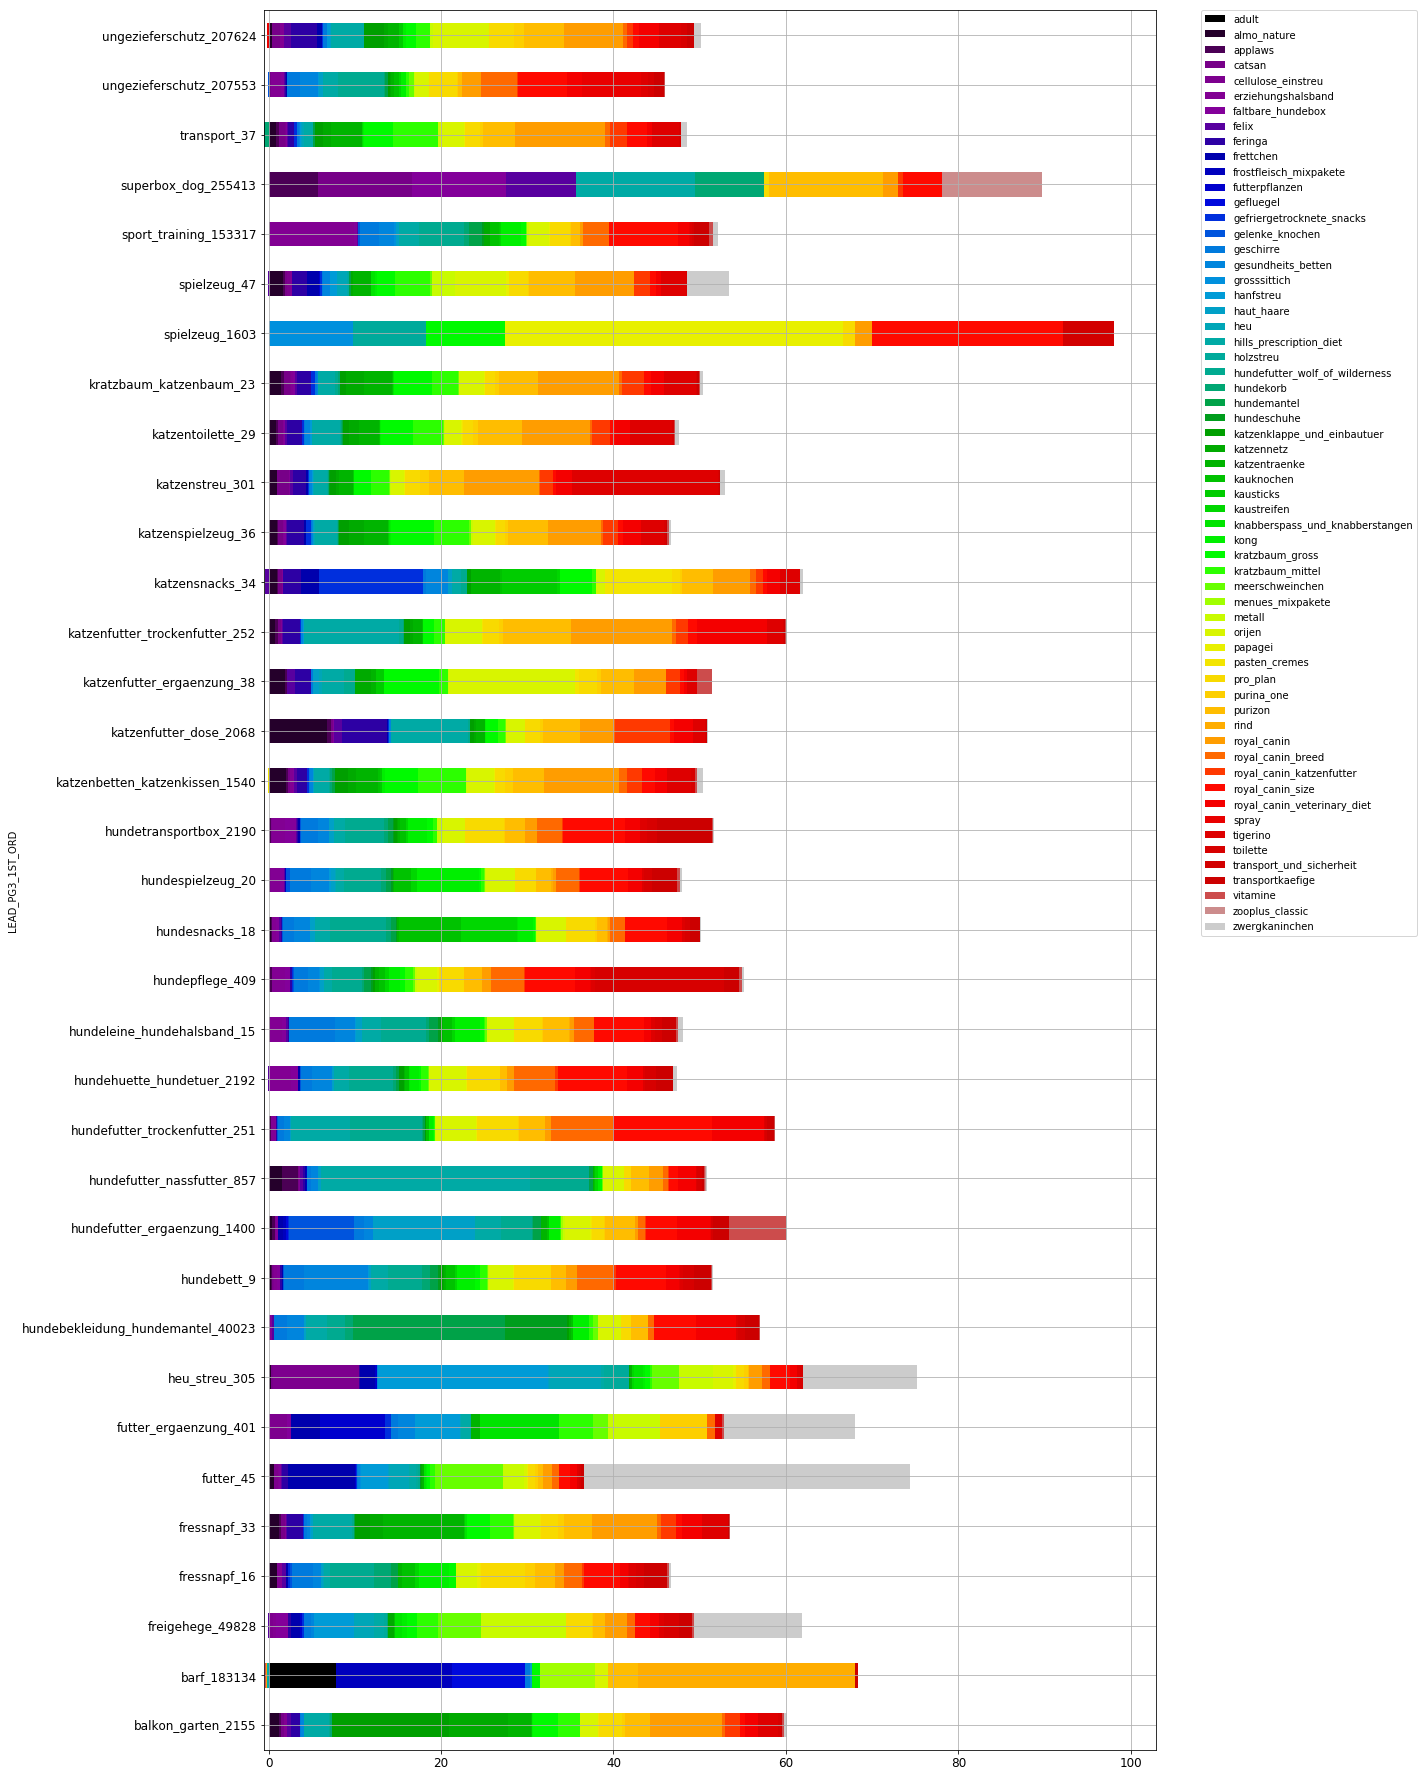

In [69]:
crosstab_pg3_to_pg4_perc_cm2[crosstab_pg3_to_pg4_perc_cm2.index != 'geschenkgutscheine_17947'][pg4_cm2_selection]\
.plot(kind='barh', stacked=True, figsize=(16, 32), grid=True, fontsize=12, colormap='nipy_spectral')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [70]:
cm2_pg3_to_pg4.sample(10)

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,OSP_3_LEAD_P_PG_ID,LEAD_PG3_NAME,OSP_4_LEAD_P_PG_ID,LEAD_PG4_NAME,LEAD_PG3_1ST_ORD,SCM_D_FINANCE_CM2,OSP_KO_COUNT_NET,REL_CM2,SCM_D_ORIG_FINANCE_ORDER_NET
231326,97852299,2017-11-06,18448317,23,kratzbaum_katzenbaum_23,2060,kratzbaum_mittel,kratzbaum_katzenbaum_23,11.5187,1,17.972218,64.0917
90477,92966515,2017-08-22,17683860,251,hundefutter_trockenfutter_251,719,hills,hundefutter_trockenfutter_251,-2.6509,1,-7.789136,34.0333
259157,98763549,2017-11-20,18589498,20,hundespielzeug_20,350,beschaeftigung,hundespielzeug_20,11.5212,1,27.678492,41.6251
75428,92359893,2017-08-11,17581167,9,hundebett_9,30936,gesundheits_betten,hundebett_9,9.0417,1,19.112251,47.3084
65495,91952699,2017-08-04,17519971,252,katzenfutter_trockenfutter_252,31963,hills_prescription_diet,katzenfutter_trockenfutter_252,-0.0806,1,-0.221429,36.4000
484677,112064571,2018-06-04,18614701,252,katzenfutter_trockenfutter_252,683,royal_canin,katzenfutter_trockenfutter_252,5.8809,3,10.703911,54.9416
387246,103941793,2018-02-04,18941808,252,katzenfutter_trockenfutter_252,95904,purizon,katzenfutter_trockenfutter_252,11.2731,2,19.534591,57.7084
113424,93847385,2017-09-05,17563376,1400,hundefutter_ergaenzung_1400,1411,vitamine,hundepflege_409,5.4668,3,16.404501,33.3250
210066,97219467,2017-10-28,17248444,252,katzenfutter_trockenfutter_252,683,royal_canin,hundefutter_trockenfutter_251,3.8885,4,14.590994,26.6500
358936,102318080,2018-01-11,17493034,252,katzenfutter_trockenfutter_252,81431,royal_canin_vet_care_nutrition,katzenfutter_trockenfutter_252,0.2313,3,0.867917,26.6500


In [71]:
cm2_pg3_to_pg4['REL_CM2'].describe()

count    4.948720e+05
mean    -1.196598e+12
std      8.417723e+14
min     -5.921627e+17
25%      3.434370e+00
50%      1.035979e+01
75%      1.823478e+01
max      4.137390e+07
Name: REL_CM2, dtype: float64

As we have some orders with net_sales = 0, CM2% becames extremely high or low and can lead us into trouble when calculating the CM2% on average per Lead PG4

In [72]:
cm2_pg3_to_pg4_subset = cm2_pg3_to_pg4[cm2_pg3_to_pg4['SCM_D_ORIG_FINANCE_ORDER_NET'] >= 1]

In [73]:
next_orders_subset = cm2_pg3_to_pg4_subset[cm2_pg3_to_pg4_subset['OSP_KO_COUNT_NET'] != 1]

In [74]:
pg3_orders_count_net_cm2 = pd.crosstab(cm2_pg3_to_pg4_subset['LEAD_PG3_1ST_ORD'], cm2_pg3_to_pg4_subset['OSP_KO_COUNT_NET'], 
                                           values = cm2_pg3_to_pg4_subset['REL_CM2'],
                                          aggfunc='mean').fillna(0).round(2)

In [75]:
pg3_orders_count_net_cm2

OSP_KO_COUNT_NET,1,2,3,4,5
LEAD_PG3_1ST_ORD,,,,,
balkon_garten_2155,15.40,13.34,12.63,12.69,13.27
barf_183134,18.03,20.13,19.48,18.55,19.75
freigehege_49828,22.65,15.73,16.43,15.61,16.47
fressnapf_16,15.02,13.59,14.61,14.39,13.59
fressnapf_33,16.61,13.62,15.23,14.18,14.44
futter_45,13.61,14.30,16.14,17.42,17.42
futter_ergaenzung_401,15.31,14.57,14.92,15.38,17.31
heu_streu_305,15.50,15.49,16.04,17.93,18.89
hundebekleidung_hundemantel_40023,32.92,21.91,16.78,16.85,16.01


In [76]:
crosstab_pg3_to_pg4_rel_cm2 = pd.crosstab(next_orders_subset['LEAD_PG3_1ST_ORD'], next_orders_subset['LEAD_PG4_NAME'], 
                                           values = next_orders_subset['REL_CM2'],
                                          aggfunc='mean').fillna(0).round(2)

In [77]:
crosstab_pg3_to_pg4_rel_cm2

LEAD_PG4_NAME,_lampen,acana,adult,advance,advance_breed,affinity_advance,affinity_advance_veterinary_diets,affinity_ultima,agility,algenbekaempfung,...,zahnpflege_snacks,zimmerkaefig,zoolove,zoolove_snacks,zooplus,zooplus_bio,zooplus_classic,zooplus_geschenkgutschein,zubehoer,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,0.00,20.58,0.00,0.00,0.00,-4.04,0.00,-4.45,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,18.58
barf_183134,0.00,22.96,30.47,0.00,0.00,0.00,-3.15,0.00,0.00,0.00,...,21.01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
freigehege_49828,0.00,14.83,0.00,0.00,0.00,0.00,14.72,2.34,39.05,0.00,...,16.39,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,13.42
fressnapf_16,0.00,19.44,0.00,0.00,0.00,0.00,-4.50,-3.56,18.22,0.00,...,16.27,30.10,0.00,0.00,0.00,0.00,0.00,0.0,0.00,31.94
fressnapf_33,0.00,21.12,0.00,0.00,16.99,-4.34,-6.84,-6.97,24.79,0.00,...,9.52,0.00,25.29,0.00,0.00,0.00,0.00,0.0,30.96,23.58
futter_45,0.00,0.00,0.00,0.00,0.00,11.15,4.00,2.90,31.88,0.00,...,14.91,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,16.05
futter_ergaenzung_401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28.63,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,13.85
heu_streu_305,0.00,24.89,0.00,0.00,0.00,0.00,2.17,8.57,0.00,0.00,...,16.13,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,13.58
hundebekleidung_hundemantel_40023,0.00,17.14,0.00,22.67,0.23,0.00,7.12,10.54,41.49,0.00,...,2.50,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [78]:
crosstab_pg3_to_pg4_rel_cm2.columns.ravel()

array(['_lampen', 'acana', 'adult', 'advance', 'advance_breed',
       'affinity_advance', 'affinity_advance_veterinary_diets',
       'affinity_ultima', 'agility', 'algenbekaempfung',
       'alle_hundenaepfe', 'alle_zubehoerartikel', 'almo_nature',
       'almo_nature_holistic', 'almo_nature_labels', 'alpha_spirit',
       'animonda', 'animonda_rafine', 'animonda_rafinee',
       'antizug_maulkorb', 'applaws', 'applaws_katzenfutter',
       'applaws_natures_calling', 'aquarien_komplett',
       'aquarium_aussenfilter', 'aquarium_filter',
       'aquarium_unterschrank', 'aquarium_zubehoer', 'arden_grange',
       'arden_grange_katzenfutter', 'arden_grange_partners',
       'aufbau_leistung_zucht', 'augen_ohren', 'augen_ohrenpflege',
       'augenpflege', 'aussergewoehnliche_katzenbetten',
       'autoschondecken', 'autoschutzgitter', 'bade_sand', 'badehaeuser',
       'baelle', 'baldrian_katzenspielzeug', 'barking_heads', 'beaphar',
       'beaphar_spezialdiaet', 'belcando', 'benek', 

In [79]:
pg4_rel_cm2_selection = [i for i in crosstab_pg3_to_pg4_rel_cm2.columns if (crosstab_pg3_to_pg4_rel_cm2[i] < 0).any()]

In [80]:
len(pg4_rel_cm2_selection)

167

In [81]:
np.array(pg4_rel_cm2_selection)

array(['advance_breed', 'affinity_advance',
       'affinity_advance_veterinary_diets', 'affinity_ultima',
       'alle_zubehoerartikel', 'almo_nature_holistic',
       'almo_nature_labels', 'applaws', 'augen_ohren',
       'augen_ohrenpflege', 'augenpflege', 'badehaeuser', 'baelle',
       'baldrian_katzenspielzeug', 'barking_heads', 'beaphar',
       'biskuits_kekse', 'bozita', 'brekkies', 'brekkies_katzenfutter',
       'brit_cat', 'buersten', 'carnilove_katzenfutter_trocken',
       'cat_chow', 'catnip_spielzeug', 'cats_best', 'catsan', 'cavalor',
       'cellulose_einstreu', 'cesar', 'clicker_pfeife', 'degu',
       'deo_geruchsbinder', 'dog_chow', 'dogmio_trockenfutter',
       'drops_leckerli', 'edelstahl', 'erziehungshilfen',
       'exklusive_katzentoilette', 'extreme_classic', 'felix', 'feringa',
       'fernhaltespray', 'flexi_new_comfort', 'flockenfutter', 'frisbee',
       'friskies', 'frolic', 'funktionsleine', 'futterbeutel_dummy',
       'futterpflanzen', 'gefriergetroc

In [82]:
pd.options.display.float_format = '{:.2f}'.format
crosstab_pg3_to_pg4_rel_cm2[pg4_rel_cm2_selection]

LEAD_PG4_NAME,advance_breed,affinity_advance,affinity_advance_veterinary_diets,affinity_ultima,alle_zubehoerartikel,almo_nature_holistic,almo_nature_labels,applaws,augen_ohren,augen_ohrenpflege,...,vitamine,vom_fisch,vom_lamm,vom_schwein,weitere_produkte,whiskas,whiskas_katzenfutter,zahnpflege_snacks,zoolove_snacks,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,0.00,-4.04,0.00,-4.45,0.00,9.52,0.00,10.83,0.00,-3.07,...,19.66,0.00,0.00,20.15,0.00,12.85,5.55,0.00,0.00,18.58
barf_183134,0.00,0.00,-3.15,0.00,0.00,0.63,0.00,0.00,0.00,0.00,...,-8.05,0.00,0.00,23.51,0.00,0.00,0.00,21.01,0.00,0.00
freigehege_49828,0.00,0.00,14.72,2.34,0.00,0.00,0.00,0.00,0.00,17.45,...,24.60,0.00,0.00,0.00,0.00,0.00,4.30,16.39,0.00,13.42
fressnapf_16,0.00,0.00,-4.50,-3.56,17.78,12.48,0.00,0.00,0.00,4.50,...,23.93,35.26,0.00,22.75,0.00,0.00,0.00,16.27,0.00,31.94
fressnapf_33,16.99,-4.34,-6.84,-6.97,15.83,9.70,0.00,11.00,0.00,14.94,...,18.01,0.00,0.00,23.13,0.00,12.86,6.07,9.52,0.00,23.58
futter_45,0.00,11.15,4.00,2.90,0.00,0.00,0.00,0.00,0.00,25.38,...,21.60,0.00,0.00,0.00,0.00,18.07,5.39,14.91,0.00,16.05
futter_ergaenzung_401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,19.98,0.00,0.00,0.00,0.00,0.00,2.24,0.00,0.00,13.85
heu_streu_305,0.00,0.00,2.17,8.57,0.00,0.00,0.00,0.00,0.00,27.08,...,0.00,0.00,0.00,0.00,0.00,8.10,15.73,16.13,0.00,13.58
hundebekleidung_hundemantel_40023,0.23,0.00,7.12,10.54,0.00,0.00,0.00,0.00,0.00,0.00,...,15.76,0.00,0.00,-22.46,0.00,0.00,7.93,2.50,0.00,0.00


In [83]:
crosstab_pg3_to_pg4_rel_cm2[pg4_rel_cm2_selection].to_csv('fr_relative_cm2_lead_pg3_and_pg4_selection.csv',
                                                          sep=';', index=True, encoding='utf-8')

In [84]:
pd.crosstab(next_orders_subset['LEAD_PG3_1ST_ORD'], next_orders_subset['LEAD_PG4_NAME'], 
                                           values = next_orders_subset['REL_CM2'],
                                          aggfunc=[len, np.mean]).fillna(0).round(2).reorder_levels([1, 0], axis=1).sort_index(axis=1)

LEAD_PG4_NAME                     _lampen        acana       adult        \
                                      len mean     len  mean   len  mean   
LEAD_PG3_1ST_ORD                                                           
balkon_garten_2155                   0.00 0.00    9.00 20.58  0.00  0.00   
barf_183134                          0.00 0.00    3.00 22.96 12.00 30.47   
freigehege_49828                     0.00 0.00    2.00 14.83  0.00  0.00   
fressnapf_16                         0.00 0.00   19.00 19.44  0.00  0.00   
fressnapf_33                         0.00 0.00   21.00 21.12  0.00  0.00   
futter_45                            0.00 0.00    0.00  0.00  0.00  0.00   
futter_ergaenzung_401                0.00 0.00    0.00  0.00  0.00  0.00   
heu_streu_305                        0.00 0.00    1.00 24.89  0.00  0.00   
hundebekleidung_hundemantel_40023    0.00 0.00    5.00 17.14  0.00  0.00   
hundebett_9                          1.00 6.59   72.00 16.66  2.00 28.40   
hundefutter_ergaenzung_1400          2.00 5.71    8.00 20.15  0.00  0.00   
hundefutter_nassfutter_857           0.00 0.00   19.00 18.81  0.00  0.00   
hundefutter_trockenfutter_251        0.00 0.00 1423.00 17.89  6.00 25.33   
hundehuette_hundetuer_2192           0.00 0.00    9.00 19.81  0.00  0.00   
hundeleine_hundehalsband_15          0.00 0.00   26.00 17.85  0.00  0.00   
hundepflege_409                      0.00 0.00   25.00 15.57  0.00  0.00   
hundesnacks_18                       0.00 0.00   36.00 18.17  0.00  0.00   
hundespielzeug_20                    0.00 0.00   50.00 17.11  1.00 24.71   
hundetransportbox_2190               0.00 0.00   46.00 18.55  0.00  0.00   
katzenbetten_katzenkissen_1540       0.00 0.00    5.00 18.83  0.00  0.00   
katzenfutter_dose_2068               0.00 0.00   45.00 20.56  0.00  0.00   
katzenfutter_ergaenzung_38           0.00 0.00    1.00 30.78  0.00  0.00   
katzenfutter_trockenfutter_252       0.00 0.00  324.00 21.53  1.00 25.12   
katzensnacks_34                      0.00 0.00    1.00 18.41  0.00  0.00   
katzenspielzeug_36                   0.00 0.00   11.00 19.02  0.00  0.00   
katzenstreu_301                      0.00 0.00   18.00 20.73  0.00  0.00   
katzentoilette_29                    0.00 0.00    6.00 19.23  0.00  0.00   
kratzbaum_katzenbaum_23              0.00 0.00   30.00 19.72  1.00 21.44   
spielzeug_1603                       0.00 0.00    0.00  0.00  0.00  0.00   
spielzeug_47                         0.00 0.00    0.00  0.00  0.00  0.00   
sport_training_153317                0.00 0.00   11.00 19.11  0.00  0.00   
superbox_dog_255413                  0.00 0.00    0.00  0.00  0.00  0.00   
transport_37                         0.00 0.00    3.00 20.79  0.00  0.00   
ungezieferschutz_207553              0.00 0.00    8.00 19.31  0.00  0.00   
ungezieferschutz_207624              0.00 0.00    0.00  0.00  0.00  0.00   

LEAD_PG4_NAME                     advance       advance_breed        ...    \
                                      len  mean           len  mean  ...     
LEAD_PG3_1ST_ORD                                                     ...     
balkon_garten_2155                   0.00  0.00          0.00  0.00  ...     
barf_183134                          0.00  0.00          0.00  0.00  ...     
freigehege_49828                     0.00  0.00          0.00  0.00  ...     
fressnapf_16                         0.00  0.00          0.00  0.00  ...     
fressnapf_33                         0.00  0.00          2.00 16.99  ...     
futter_45                            0.00  0.00          0.00  0.00  ...     
futter_ergaenzung_401                0.00  0.00          0.00  0.00  ...     
heu_streu_305                        0.00  0.00          0.00  0.00  ...     
hundebekleidung_hundemantel_40023    1.00 22.67          1.00  0.23  ...     
hundebett_9                          1.00 24.79          4.00 -0.09  ...     
hundefutter_ergaenzung_1400          6.00 20.14          4.00 22.41  ...     
hundefutter_nassfut

In [85]:
ord_cm2_crosstab_pg4 = pd.crosstab(next_orders_subset['LEAD_PG3_1ST_ORD'], next_orders_subset['LEAD_PG4_NAME'], 
                                           values = next_orders_subset['REL_CM2'],
                                          aggfunc=[len, np.mean]).fillna(0).round(2).reorder_levels([1, 0], axis=1).sort_index(axis=1)

In [86]:
ord_cm2_crosstab_pg4[pg4_rel_cm2_selection].to_csv('fr_n_ord_avg_cm2_per_pg4.csv',
                                                  sep=';', index=True, encoding='utf-8')

In [87]:
neg_brands = []

for i in ord_cm2_crosstab_pg4[pg4_rel_cm2_selection].columns.levels[0]:
    for j in list(zip(ord_cm2_crosstab_pg4[i]['len'], ord_cm2_crosstab_pg4[i]['mean'])):
        if (j[0] > 10 and j[1] < 0):
            neg_brands.append(i)

In [88]:
set_neg_brands = list(set(neg_brands))

In [89]:
set_neg_brands

['baldrian_katzenspielzeug',
 'kausnacks_natur_vom_rind',
 'ratte',
 'virbac_vethpm',
 'knuspersnacks',
 'barking_heads',
 'dog_chow',
 'kunststoff',
 'gefriergetrocknete_snacks',
 'schalentoiletten',
 'spielangeln',
 'hundekorb',
 'friskies',
 'halsband',
 'affinity_ultima',
 'spoton',
 'deo_geruchsbinder',
 'whiskas_katzenfutter',
 'baelle',
 'spielmaeuse',
 'hills',
 'keramik',
 'cesar',
 'buersten']

In [90]:
ord_cm2_crosstab_pg4[set_neg_brands]

LEAD_PG4_NAME                     baldrian_katzenspielzeug          \
                                                       len    mean   
LEAD_PG3_1ST_ORD                                                     
balkon_garten_2155                                    2.00   21.18   
barf_183134                                           0.00    0.00   
freigehege_49828                                      1.00   29.65   
fressnapf_16                                          0.00    0.00   
fressnapf_33                                          3.00   29.34   
futter_45                                             0.00    0.00   
futter_ergaenzung_401                                 1.00   13.83   
heu_streu_305                                         0.00    0.00   
hundebekleidung_hundemantel_40023                     0.00    0.00   
hundebett_9                                           0.00    0.00   
hundefutter_ergaenzung_1400                           0.00    0.00   
hundefutter_nassfutter_857                            0.00    0.00   
hundefutter_trockenfutter_251                         0.00    0.00   
hundehuette_hundetuer_2192                            0.00    0.00   
hundeleine_hundehalsband_15                           0.00    0.00   
hundepflege_409                                       0.00    0.00   
hundesnacks_18                                        0.00    0.00   
hundespielzeug_20                                     1.00 -165.48   
hundetransportbox_2190                                0.00    0.00   
katzenbetten_katzenkissen_1540                        4.00   -4.73   
katzenfutter_dose_2068                                3.00   13.38   
katzenfutter_ergaenzung_38                            0.00    0.00   
katzenfutter_trockenfutter_252                       12.00  -57.75   
katzensnacks_34                                       0.00    0.00   
katzenspielzeug_36                                    9.00   23.44   
katzenstreu_301                                       1.00 -182.47   
katzentoilette_29                                     9.00  -46.79   
kratzbaum_katzenbaum_23                               4.00  -21.40   
spielzeug_1603                                        0.00    0.00   
spielzeug_47                                          0.00    0.00   
sport_training_153317                                 0.00    0.00   
superbox_dog_255413                                   0.00    0.00   
transport_37                                          0.00    0.00   
ungezieferschutz_207553                               0.00    0.00   
ungezieferschutz_207624                               1.00   14.72   

LEAD_PG4_NAME                     kausnacks_natur_vom_rind       ratte  \
                                                       len  mean   len   
LEAD_PG3_1ST_ORD                                                         
balkon_garten_2155                                    0.00  0.00  0.00   
barf_183134                                           0.00  0.00  0.00   
freigehege_49828                                      0.00  0.00  2.00   
fressnapf_16                                          4.00 20.75  1.00   
fressnapf_33                                          0.00  0.00  0.00   
futter_45                                             0.00  0.00 55.00   
futter_ergaenzung_401                                 0.00  0.00  3.00   
heu_streu_305                                         0.00  0.00 22.00   
hundebekleidung_hundemantel_40023                     5.00 11.47  0.00   
hundebett_9                                          14.00 15.62  4.00   
hundefutter_ergaenzung_1400                           2.00 20.86  0.00   
hundefutter_nassfutter_857                            4.00 10.31  0.00   
hundefutter_trockenfutter_251                        47.00 -0.13  5.00   
hundehuette_hundetuer_2192                            2.00 28.34  1.00   
hundeleine_hundehalsband_15                          11.00 12.29  0.00   
hundepf

In [91]:
ord_cm2_crosstab_pg4[set_neg_brands].to_csv('fr_set_neg_brands.csv', sep=';', index=True, encoding='utf-8')

In [92]:
next_orders_subset.groupby('LEAD_PG4_NAME')['REL_CM2'].mean()['halsband']

-3.8117432738219357

In [93]:
next_orders_subset.groupby('LEAD_PG4_NAME')['REL_CM2'].mean()['animonda']

18.50716724817785

In [94]:
next_orders_subset.groupby('LEAD_PG4_NAME')['REL_CM2'].mean()['earthborn']

5.60972247575607

In [95]:
writer = pd.ExcelWriter('FR_from_lead_pg3_1st_order_to_pg4.xlsx', engine='xlsxwriter')

workbook = writer.book
format1 = workbook.add_format({'num_format': '0.00'})

crosstab_pg3_to_pg4_orders[pg4_selection].to_excel(writer, sheet_name='%from_total_orders_and_pg4', index=True, encoding='utf-8')
crosstab_pg3_to_pg4_perc_cm2[pg4_cm2_selection].to_excel(writer, sheet_name='%from_total_cm2_and_pg4', index=True, encoding='utf-8')
crosstab_pg3_to_pg4_rel_cm2[pg4_rel_cm2_selection].to_excel(writer, sheet_name='avg_cm2%_per_pg4', index=True, encoding='utf-8')
ord_cm2_crosstab_pg4[pg4_rel_cm2_selection].to_excel(writer, sheet_name='ord_avg_cm2%_per_pg4', index=True, encoding='utf-8')
ord_cm2_crosstab_pg4[set_neg_brands].to_excel(writer, sheet_name='set_neg_brands', index=True, encoding='utf-8')

writer.save()